# Claim management - Exploratory Analysis

## Importing libraries

In [2]:
# importing libraries.
import pandas as pd
import numpy as np
import random
from collections import Counter, defaultdict

# importing tools
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score

# importing models
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.lda import LDA
#from sklearn.qda import QDA
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, classification_report

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Reading datasets (train and test) and looking at basic information

In [43]:
# Reading the train & test sets
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [44]:
# dimensions 
print df_train.shape, df_test.shape

# numbers of rows for train & test sets
num_rows_train = df_train.shape[0]
num_rows_test = df_test.shape[0]

# number of variables
num_variables = df_test.shape[1] - 1 # ID column should not be counted
print num_variables

(114321, 133) (114393, 132)
131


If we exclude ID and the target variable, there are 131 variables. As expected, the test set doesn't have the target variable.

In [45]:
# Check if ID has null and duplicates.
print df_train['ID'].isnull().sum(), \
    len(df_train['ID'].unique()) == df_train.shape[0]
print df_test['ID'].isnull().sum(), \
    len(df_test['ID'].unique()) == df_test.shape[0]

0 True
0 True


In [46]:
# Set ID as index
df_train.set_index('ID', inplace=True)
df_test.set_index('ID', inplace=True)

# Target is separated from df_train.
target_train = df_train.pop('target')

In [47]:
# Saving null locations.
df_train_isnull = df_train.isnull()
df_test_isnull = df_test.isnull()

In [48]:
# column names
column_names = df_test.columns
print column_names

Index([u'v1', u'v2', u'v3', u'v4', u'v5', u'v6', u'v7', u'v8', u'v9', u'v10', 
       ...
       u'v122', u'v123', u'v124', u'v125', u'v126', u'v127', u'v128', u'v129',
       u'v130', u'v131'],
      dtype='object', length=131)


In [9]:
# The ratio of target value 1
target_prob_train = target_train.mean()
print target_prob_train

0.761198729892


## Exploring category variables

In [10]:
# indices of category variables by looking at the data (23 out of 131)
category_variables = [2, 21, 23, 29, 30, 37, 46, 51, 55, 61,
                      65, 70, 71, 73, 74, 78, 90, 106, 109, 111,
                      112, 124, 128]
category_variable_names = column_names[category_variables]

# The rest of variables are numerical variables.
numerical_variables = [i for i in range(num_variables) if i not in category_variables]

# Find unique values for train & test sets.
unique_values = {}
for ind in category_variables:
    unique_values[ind] = set(df_train.iloc[:,ind].unique())
    print df_train.columns[ind] + ":", df_train.iloc[:,ind].nunique(), df_test.iloc[:,ind].nunique()

v3: 3 3
v22: 18210 18252
v24: 5 5
v30: 7 7
v31: 3 3
v38: 12 12
v47: 10 9
v52: 12 12
v56: 122 116
v62: 8 8
v66: 3 3
v71: 9 9
v72: 13 13
v74: 3 3
v75: 4 4
v79: 18 17
v91: 7 7
v107: 7 7
v110: 3 3
v112: 22 22
v113: 36 36
v125: 90 90
v129: 10 10


Except the column 'v22' (18,211 values), all category variables have less than 100 values.

In [11]:
# Function to compare two lists (assumming both lists have unique values)
def list_compare(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    return set1 == set2

In [12]:
# Checking if unique values are the same for category variables
for i in category_variables:
    print df_train.columns[i], list_compare(df_train.iloc[:,i].unique(), \
                       df_test.iloc[:,i].unique())

v3 True
v22 False
v24 True
v30 True
v31 True
v38 True
v47 False
v52 True
v56 False
v62 True
v66 True
v71 False
v72 True
v74 True
v75 True
v79 False
v91 True
v107 True
v110 True
v112 True
v113 False
v125 True
v129 True


6 variables (v22, v47, v56, v71, v79, v113) have different values in train & test sets.

In [50]:
# Also there are 4 category variables with integers (v38, v62, v72, v129), and they have no null.
print df_train.isnull().sum(axis=0)[[37, 61, 71, 128]]
print df_test.isnull().sum(axis=0)[[37, 61, 71, 128]]

v38     0
v62     0
v72     0
v129    0
dtype: int64
v38     0
v62     0
v72     0
v129    0
dtype: int64


In [49]:
# For some of other category variables.
print df_train.isnull().sum(axis=0)[[21, 55, 78, 30, 112, 46, 109, 65]]
print df_test.isnull().sum(axis=0)[[21, 55, 78, 30, 112, 46, 109, 65]]

v22       500
v56      6882
v79         0
v31      3457
v113    55304
v47         0
v110        0
v66         0
dtype: int64
v22       477
v56      6918
v79         0
v31      3492
v113    55358
v47         0
v110        0
v66         0
dtype: int64


In [14]:
# From here on, missing values of category variables will be replaced with a string 'null',
# which means that missing values will be treated as another category.
df_train.iloc[:, category_variables] = df_train.iloc[:, category_variables].replace(np.nan, 'null')
df_test.iloc[:, category_variables] = df_test.iloc[:, category_variables].replace(np.nan, 'null')

In [15]:
# If a new value appears in a test set
# (which is not in training set), it will be also replaced by 'null'. 
# This function is called for each row.
def replace_with_null(row, category_variables, unique_values):
    for j, ind in enumerate(category_variables):
        #print i, ind+1, df_test2.iloc[i, ind]
        if row[ind] != 'null' and row[ind] not in unique_values[j]:
            #print i, ind+1, df_test.iloc[i, ind]
            row[ind] = 'null'
    return row

In [16]:
# Function to plot distributions of category variables (for train and test sets) 
#     and how much of each value has target 1 in the train set.
# data frames are assumed to be with independent variables and target is a separate series with 0 and 1.
# It also treats missing values as another value.
def plot_category_variables(df_train, df_test, target, category_variable_names):
    num_variables = len(category_variable_names)
    target_column_name = 'target'
    df_train_category = df_train[category_variable_names].copy()
    df_test_category = df_test[category_variable_names]
    
    df_train_category[target_column_name] = target
    fig, axs = plt.subplots(3, len(category_variable_names), figsize=(13,10))
    for i, variable_name in enumerate(category_variable_names):
        counts_train = df_train_category.groupby(variable_name).size()
        counts_train.plot(kind='bar', ax=axs[0,i] if num_variables > 1 else axs[0], color='b', alpha=0.5)
        counts_test = df_test_category.groupby(variable_name).size()
        counts_test.plot(kind='bar', ax=axs[1,i] if num_variables > 1 else axs[1], color='g', alpha=0.5)
        ratios = df_train_category.groupby(variable_name)[target_column_name].mean()
        ratios.plot(kind='bar', ax=axs[2,i] if num_variables > 1 else axs[2], color='r', alpha =0.5)
        
    #plt.tight_layout()
    plt.suptitle('Total Counts and ratios of target 1')
    plt.show()

In the plots below, the first row represents the distribution of values in the train set, the second row represents those in the test sets, and the third row represents the ratio of target 1 for each value in the train set. (The average is 0.76 overall.) Since v22 and v56 have too many values. We don't look at them in the plots.

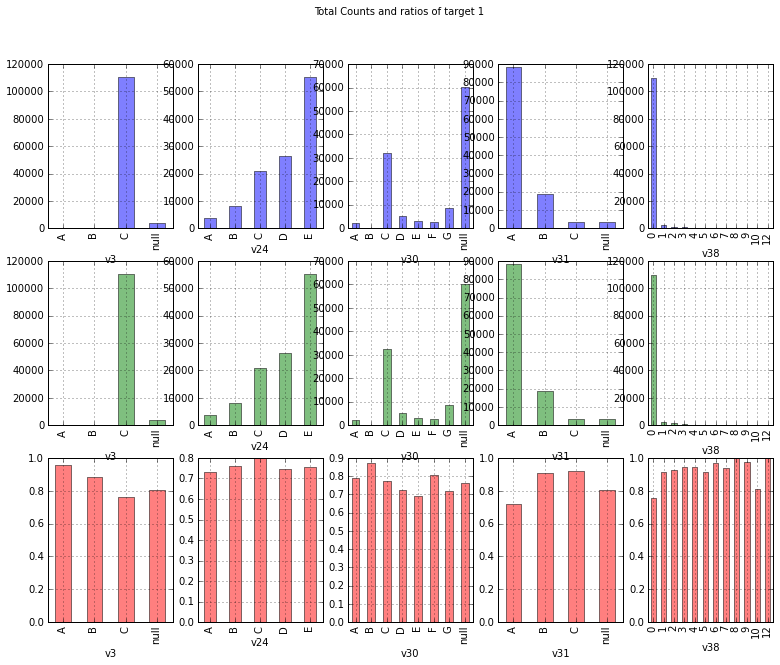

In [17]:
plot_category_variables(df_train, df_test, target_train, \
                        column_names[[category_variables[0]] + category_variables[2:6]])

For example in v3, almost all data has 'C' and for other values there is no predictable value in it. Therefore we can ignore this variable, v3. By just looking at plots, except v31, there is no predictive value, it seems.

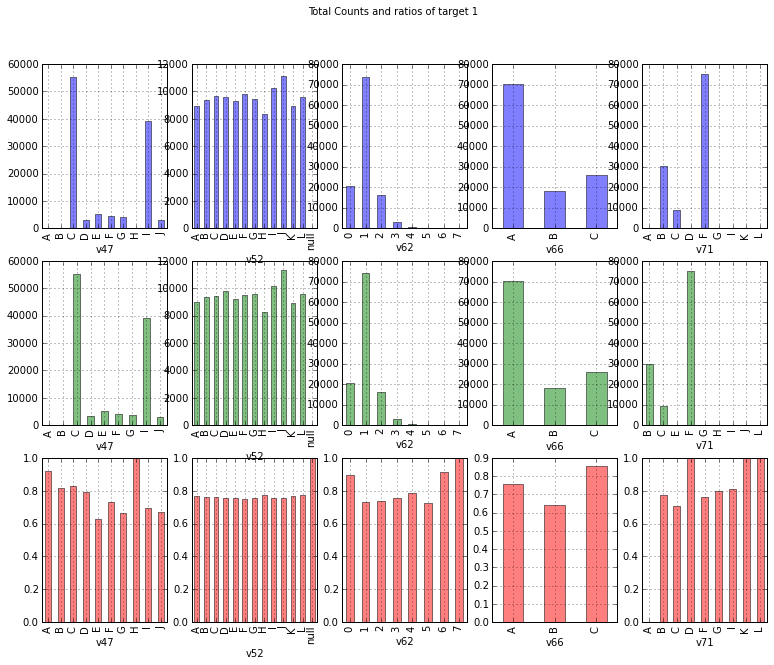

In [18]:
plot_category_variables(df_train, df_test, target_train, \
                        column_names[category_variables[6:8] + category_variables[9:12]])

Except v47, v62, and v66, there is no predictive value, it seems. For v56, it's hard to tell.

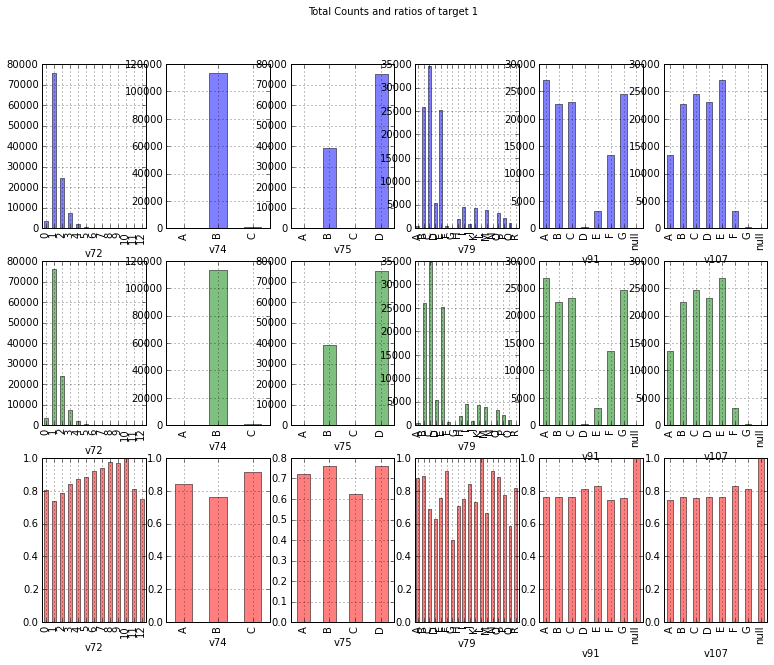

In [19]:
plot_category_variables(df_train, df_test, target_train, column_names[category_variables[12:18]])

Except v79, there is no predictive value, it seems. Also v91 and v107 are the same variable with different labels. Hence we can drop one without losing anything.

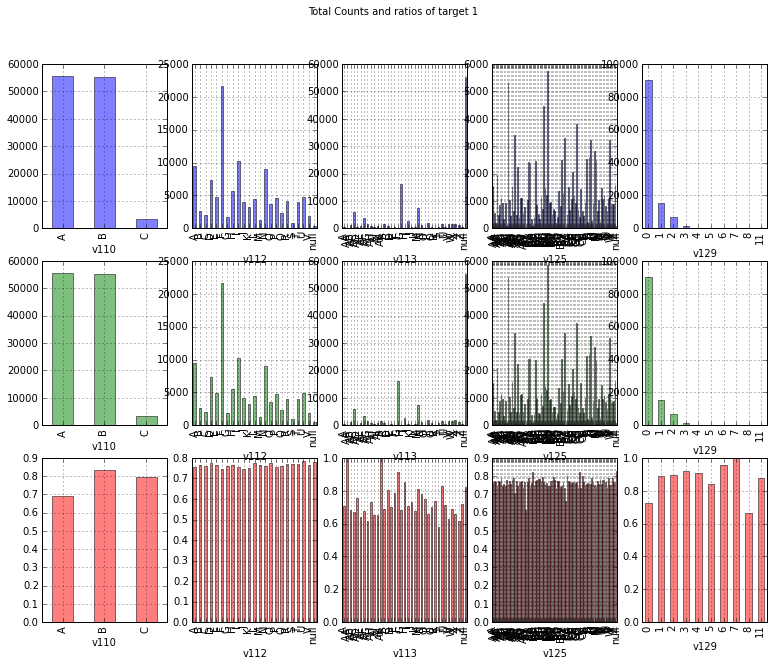

In [20]:
plot_category_variables(df_train, df_test, target_train, column_names[category_variables[18:24]])

Except v110, v113, and v129, there is no predictive value, it seems. 

Above plots show two things: (1) trains set and test set have almost the same distributions (the first and the second row); (2) the ratio of target value 1 for each value of category variables don't change much except several variables mentioned above (v31, v47, v62, v79, v110, v129). So far we just looked at the distributions to determine statistically significant category variables (except v22 and v56).

But we need quantitative ways to find that out. One easy quantity is the variability of target probability of levels of a variable. The target probability is the probability of target 1 for the whole train set. And we can find this probability for each value of a variable. If all these values are the same as the overall target pribability, we can say that there is no statistical significance. If they are different for each value, then there is some statistical significance. To find out how different for all values, we define the quantity: 

variability = \sum_i  (n_i/N) (p_i - P)^2

where n_i is the number of i-th value, p_i is the target probability of i-th value, N is the number of all values, and P is the total target probability.

In [21]:
# To calcluate the above value for a given variable
def find_variability(df_train, target_train, category_variable_name):
    df = pd.concat([df_train[category_variable_name], target_train], axis=1)
    target_prob_train = target_train.mean()
    counts = pd.value_counts(df[category_variable_name])
    ratios = df.groupby(category_variable_name)['target'].mean()
    
    sum = 0
    for val in counts.index:
        sum  = sum + counts[val] * (ratios[val] - target_prob_train)**2
    return sum/df_train.shape[0]

Index([u'v22', u'v56', u'v79', u'v31', u'v113', u'v47', u'v110', u'v129',
       u'v66', u'v62', u'v72', u'v38', u'v30', u'v24', u'v125', u'v71', u'v91',
       u'v107', u'v74', u'v3', u'v112', u'v52', u'v75'],
      dtype='object') : [  3.28349118e-02   1.04105272e-02   7.63450858e-03   5.82624110e-03
   5.53506114e-03   5.27379633e-03   4.95283565e-03   4.69902066e-03
   4.19740140e-03   4.12306747e-03   1.41218935e-03   1.12033959e-03
   4.62165168e-04   3.73684623e-04   3.08870816e-04   2.54182177e-04
   1.86788146e-04   1.86788146e-04   1.48806884e-04   1.41593255e-04
   1.22702614e-04   4.70288265e-05   7.48164806e-06]


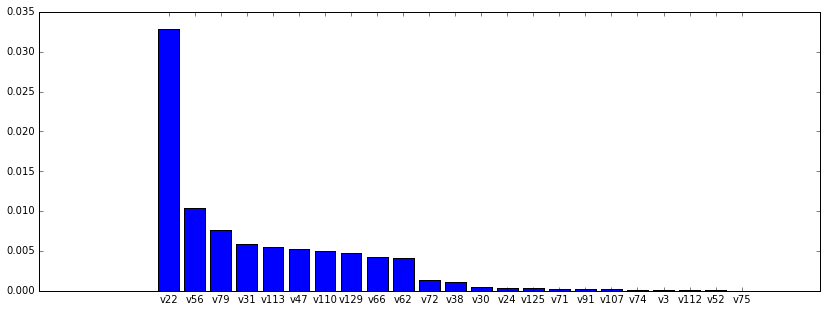

In [22]:
# print the above value for all category variables.
variabilities = np.zeros(len(category_variable_names))
#print variabilities
for i, name in enumerate(category_variable_names):
    variabilities[i] = find_variability(df_train, target_train, name)
sorted_indices = np.argsort(variabilities)[::-1]
print category_variable_names[sorted_indices], ':', variabilities[sorted_indices]

# Plotting a bar plot to visualize the result
plt.figure(figsize=(14, 5))
x_locations = np.arange(len(category_variable_names))# + 0.5
plt.bar(x_locations, variabilities[sorted_indices], align='center')
plt.xticks(range(len(variabilities)), category_variable_names[sorted_indices])
plt.show()

From above plot, we can clearly see that v22 and v56 (which has many values) are statistically siginficant variables, especially v22. And our eye test picked other 8 variables from the top 10. From here on, we will just deal with top 10 category variables. 

Now the problem is how to deal with many levels of v22 (18211 for the train set), v56 (123 for the train set) and maybe v113 (37). To do that, we first look at counts and target probabilities in 2D scatter plots for these 3 variables.

In [51]:
# To plot counts and target probabilities of a category variable in a 2D scatter plot
def plot_variability(df_train, target_train, category_variable_name, binsize=0.1):
    df = pd.concat([df_train[category_variable_name], target_train], axis=1)
    target_prob_train = target_train.mean()
    counts = pd.value_counts(df[category_variable_name]).sort_index()
    ratios = df.groupby(category_variable_name)['target'].mean().sort_index()
    plt.scatter(ratios, counts, alpha=0.5)
    plt.xlim((ratios.min()-0.05, 1.05))
    plt.title(category_variable_name)
    plt.xlabel('target probability')
    plt.ylabel('count')
    plt.axvline(x=target_prob_train, color='r')
    nlimit = int(1.0/binsize + 1)
    for i in range(-nlimit, nlimit+1):
        pos = target_prob_train + i*binsize + binsize/2.0
        if pos >= -binsize and pos <= 1.0 + binsize:
            plt.axvline(x=pos, color='g', ls='dotted')
    plt.show()

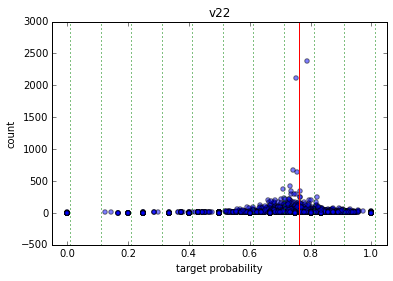

In [52]:
plot_variability(df_train, target_train, 'v22')

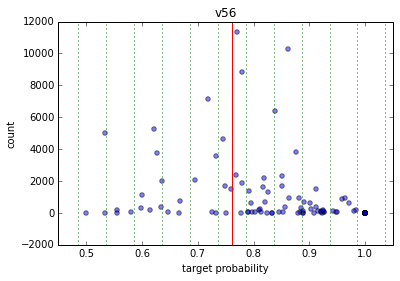

In [53]:
plot_variability(df_train, target_train, 'v56', 0.05)

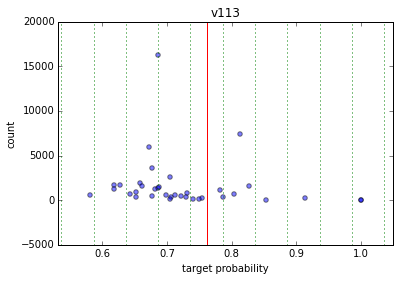

In [54]:
plot_variability(df_train, target_train, 'v113', 0.05)

Some kind of conversion is needed for these variables since we cannot just ignore them. One easy way is binning data points using the target probability of their values. For example, given the bin size of 0.1, if the values of a variable fall into the vaules inside the given bin (represented dotted lines) in above pictures, those values are merged into one category. The number of bins are about 10 for all three cases. To achieve this we need to name each bin and make a dict object to keep track of the conversion method for each variable.

One thing to keep in mind is that the variabilities we computed above can be over-represented by values with low counts. For example, when a value has appeared only once, the target probability can be either 0 or 1. But the standard deviation of this probability is very high, so the variability for that value is over-represented. If there are many values with low counts like 'v22', the overall variability can be over-represented as shown above. By just looking at the picture, 'v56' and 'v113' have higher statistical significance, and we have to keep that in mind when we convert these variables.

### Create 3 new variables by converting v22, v56, v113 using bins

In [40]:
# Given a category variable, returns a series containing the labels (0, 1, 2,..) for each value.
# Labels are found binning the target probability of each value in the train set.
def find_binning_info(df_train, target_train, variable_name, binsize=0.1):
    df = pd.concat([df_train[variable_name], target_train], axis=1)
    target_prob_train = target_train.mean()
    ratios = df.groupby(variable_name)['target'].mean()
    print variable_name + "'s target prob for null:", ratios['null']
    ratio_min = ratios.min()
    max_num_bins = int(1.0/binsize + 1) # the maximum possible number of bins.
    bin_name = [] # The name of the first bin is 0.
    bin_range = [] # Range of each bin given by a tuple.
    for i in range(-max_num_bins, max_num_bins+1):
        pos = target_prob_train + i*binsize + binsize/2.0
        if pos > ratio_min and pos < 1.0 + binsize:
            bin_min = pos - binsize
            break
    return pd.cut(ratios, bins=np.arange(bin_min, 1.0 + binsize, binsize), labels=False) # integers

In [41]:
variables_binned = [21, 55, 112]
conversion_methods = [] # dict will be elements of this list and each dict contains conversion info.
conversion_methods.append(find_binning_info(df_train, target_train, \
                                            column_names[variables_binned[0]], binsize=0.1))
conversion_methods.append(find_binning_info(df_train, target_train, \
                                            column_names[variables_binned[1]], binsize=0.05))
conversion_methods.append(find_binning_info(df_train, target_train, \
                                            column_names[variables_binned[2]], binsize=0.05))

v22's target prob for null: 0.82
v56's target prob for null: 0.622493461203
v113's target prob for null: 0.823882540142


In [29]:
# Find a new column based on conversion information found above
def find_new_variable(column, conversion, unique_values):
    col = column.copy()
    for i, v in col.iteritems():
        if v in unique_values: # unique_values: unique values from the train set.
            col[i] = conversion[v]
        else:
            col[i] = conversion['null']
    return col

In [30]:
# Add new columns for 3 variables to both train and test sets.
new_names = []
for i, ind in enumerate(variables_binned):
    df_train[column_names[ind] + 'a'] = find_new_variable(df_train[column_names[ind]], \
                                                          conversion_methods[i], unique_values[ind])
    df_test[column_names[ind] + 'a'] = find_new_variable(df_test[column_names[ind]],\
                                                         conversion_methods[i], unique_values[ind])
    new_names.append(column_names[ind] + 'a')
column_names = np.append(column_names, new_names)
print df_train.shape, df_test.shape, column_names.shape

(114321, 134) (114393, 134) (134,)


In [35]:
pd.value_counts(df_test['v22a']), pd.value_counts(df_train['v22a'])

(8     44517
 9     22996
 10    18212
 7     17268
 6      3927
 5      3918
 0      1908
 4      1247
 3       313
 2        87
 dtype: int64, 8     45236
 10    21115
 7     18371
 9     16799
 6      4217
 5      4132
 0      2526
 4      1470
 3       335
 2       120
 dtype: int64)

In [37]:
count = 0
notexist = set()
for a in df_test['v22']:
    if a not in unique_values[21]:
        count = count + 1
        notexist.add(a)
print count, count/float(df_test.shape[0]), len(notexist)

7844 0.0685706293217 5210


Distributions of values of the variable 'v22a' for train and test sets are different (see value 7). It increases in the test set because of new values that appear in the test sets. Unlike 'v56' (9 times) and 'v113' (1 time), for 'v22', 7844 times it appears, good for 7% of all test data points. If we convert all these values into 'null', as we did already, it is not good. Therefore we have to do something else for 'v22'. The above method that does not take into account the high standard deviations for low-count values does not work well especially for 'v22'.

In [30]:
# Define 10 category variables that will be considered
category_variables_top10 = [131, 132, 78, 30, 133, 46, 109, 128, 65, 61] # category variables to be considered
                            # v22, v56, v113 are replaced by new variables (v22a (131), v56a (132), v113a (133)) 

## Missing values

In [31]:
# Function to draw scatter plot of missing values based on their positions 
# in the data frame (x: column number, y: row number)
def draw_missing_values(df_isnull, num_rows=200, num_cols=200):
    num_rows = (df_isnull.shape[0] if df_isnull.shape[0] < num_rows else num_rows)
    num_cols = (df_isnull.shape[1] if df_isnull.shape[1] < num_cols else num_cols)
    chosen_rows = range(df_isnull.shape[0])
    random.shuffle(chosen_rows)
    chosen_rows = chosen_rows[:num_rows]
    
    x = []
    y = []
    for i in range(num_rows):
        #if i % 100 == 0:
        #    print "progress:", i, "out of", num_rows
        for j in range(num_cols): # columns are not randomly chosen
            if df_isnull.iloc[chosen_rows[i],j]:
                x.append(j)
                y.append(num_rows - 1 - i)
    plt.scatter(x, y, color='blue', s=0.5, alpha=0.5)

### For category variables only

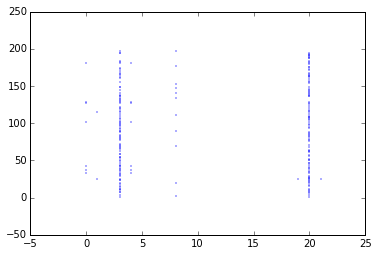

In [32]:
# Missing values for category variables only.  To observe that fact, we plot a scatter plot. 
# Here x-axis represents columns, y-axis represents rows, and points represents nulls.
draw_missing_values(df_train_isnull[category_variables])

Two columns, 'v30' and 'v113', have many missing values.

In [33]:
# percentages of nulls for only category varialbes
print "For train set:", df_train_isnull.iloc[:, category_variables].sum().sum() / \
    float(len(category_variables)*num_rows_train)
print "For test set:", df_test_isnull.iloc[:, category_variables].sum().sum() / \
    float(len(category_variables)*num_rows_test)

For train set: 0.0495089532411
For test set: 0.049631343359


About 5% of cells are nulls for category variables.

### For numerical variables only

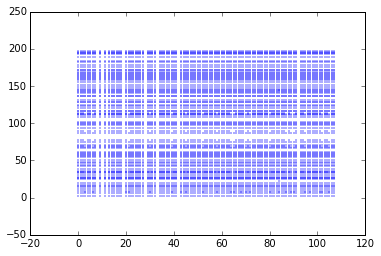

In [34]:
# draw patterns of missing values (200 rows will be chosen randomly)
# Missing values for numerical variables only.
# Here x-axis represents columns, y-axis represents rows, and points represents nulls.
draw_missing_values(df_train_isnull[numerical_variables])

Interesting to observe that there are many more nulls than category variables. With above results, we can safely say that missing values are not randomly distributed.

What we could see from this picture is that there is a pattern (MNAR: Missing Not At Random). There are clearly two groups of rows as we have seen. For the group of rows with many missing values, the columns of missing values are almost the same.

So it might be a good idea to divide the rows into two groups and to use different sets of columns (and different imputation methods) for predictions. Category variables have to be dealt differently.

In [35]:
# The percentage of cells with nulls (only looking at numerical variables)
num_nulls_by_row_train = df_train_isnull[numerical_variables].sum(axis=1)
num_nulls_by_column_train = df_train_isnull[numerical_variables].sum(axis=0)
print "For train set:", num_nulls_by_row_train.sum()/float(num_rows_train * num_variables)

num_nulls_by_row_test = df_test_isnull[numerical_variables].sum(axis=1)
num_nulls_by_column_test = df_test_isnull[numerical_variables].sum(axis=0)
print "For test set:", num_nulls_by_row_test.sum()/float(num_rows_test * num_variables)

For train set: 0.331682430836
For test set: 0.331731649891


~ 1/3 of cells for numerical variables are nulls for both train & test sets

In [36]:
# percentage of rows with no null
print "For train set:", sum(num_nulls_by_row_train == 0)/float(num_rows_train)
print "For test set:", sum(num_nulls_by_row_test == 0)/float(num_rows_test)

For train set: 0.547239789715
For test set: 0.547166347591


Seems like only 55% of rows have no null value for both train & test sets, when we look at only numerical variables. Now we will look into distributions of nulls in more detail.

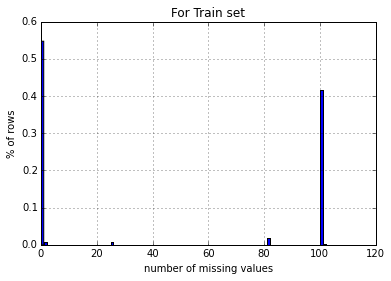

In [37]:
# The distribution of the number of null values for each row
num_nulls_by_row_train.hist(bins=108, normed=True)
plt.xlabel("number of missing values")
plt.ylabel("% of rows")
plt.title("For Train set")
plt.show()

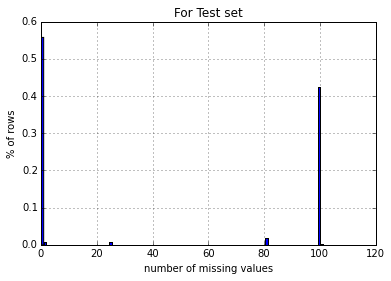

In [38]:
num_nulls_by_row_test.hist(bins=108, normed=True)
plt.xlabel("number of missing values")
plt.ylabel("% of rows")
plt.title("For Test set")
plt.show()

Above results show that more than 40% of rows have ~100 nulls out of 108 possible values. Somehow there is a peak near 100. Therefore we have to keep that in mind.  Also ~1/3 of possible values are missing. Based on these two facts, we need to find systematic ways to deal with missing data.

In [39]:
# We will do more analysis on missing data.
# First, we will select rows with more than 80 nulls.
mask_null_over_80_train = (num_nulls_by_row_train > 80)
mask_null_over_80_test = (num_nulls_by_row_test > 80)
print np.sum(mask_null_over_80_train), num_rows_train, np.sum(mask_null_over_80_train)/float(num_rows_train)
print np.sum(mask_null_over_80_test), num_rows_test, np.sum(mask_null_over_80_test)/float(num_rows_test)

49796 114321 0.435580514516
49840 114393 0.435690995078


~44% of rows have more than 80 nulls out of 108 values for both sets. If we divide the data into 2 groups based on the number of nulls (80 as the dividing point), you can compare the percentage of 1 for the target. 

In [41]:
# Percentage of target 1 out of rows with more than 80 rows.
print target_train[mask_null_over_80_train].sum()/float(sum(mask_null_over_80_train))
# Percentage of target 1 out of rows with less than 80 rows.
print target_train[~mask_null_over_80_train].sum()/float(sum(~mask_null_over_80_train))

0.770142180095
0.754296784192


They are not significantly different.
### Based on columns

In [42]:
# percentage of columns with less than 1% of nulls
print "For train set:", sum(num_nulls_by_column_train < 0.01 * num_rows_train)
print "For test set:", sum(num_nulls_by_column_test < 0.01 * num_rows_test)

For train set: 8
For test set: 8


In [43]:
# Find above 8 variables (they are the same for both train and test sets)
variables_less_null = np.array(numerical_variables)[np.where(num_nulls_by_column_train < 0.01 * num_rows_train)]
print column_names[variables_less_null]

['v10' 'v12' 'v14' 'v21' 'v34' 'v40' 'v50' 'v114']


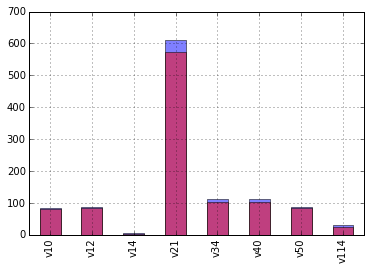

In [44]:
# Numbers of nulls for above variables
num_nulls_by_column_train[column_names[variables_less_null]].plot(kind='bar', color='b', alpha=0.5)
num_nulls_by_column_test[column_names[variables_less_null]].plot(kind='bar', color='r', alpha=0.5)
plt.show()

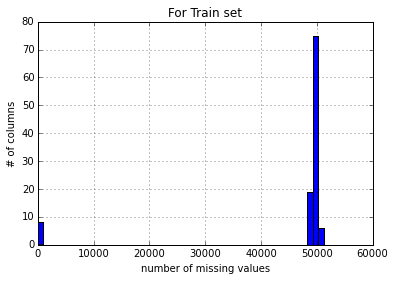

In [45]:
# We can plot distributions for all numerical variables, too.
num_nulls_by_column_train.hist(bins=50)
plt.xlabel("number of missing values")
plt.ylabel("# of columns")
plt.title("For Train set")
plt.show()

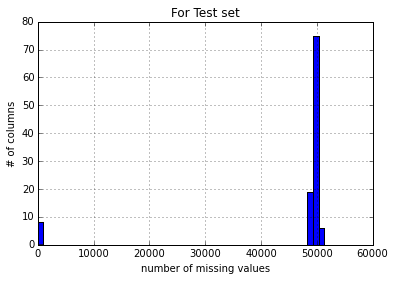

In [46]:
num_nulls_by_column_test.hist(bins=50)
plt.xlabel("number of missing values")
plt.ylabel("# of columns")
plt.title("For Test set")
plt.show()

Except 8 variables, about 1/3 of values are missing from each numerical variable. And those mostly come from 45% of rows because 55% of rows don't have a null value as shown above.

In [47]:
# Looking at these 8 variables
df_train[variables_less_null].describe()

,v10,v12,v14,v21,v34,v40,v50,v114
count,1.142370e+05,1.142350e+05,1.143170e+05,113710.000000,1.142100e+05,1.142100e+05,1.142350e+05,1.142910e+05
mean,1.883046e+00,6.881304e+00,1.209428e+01,7.029740,6.406236e+00,1.046593e+01,1.504265e+00,1.357445e+01
std,1.393979e+00,9.244945e-01,1.443947e+00,1.072271,2.025179e+00,3.169183e+00,1.168329e+00,2.613221e+00
min,-9.875317e-07,5.143224e-07,-9.738831e-07,0.106181,-6.707670e-07,1.238996e-07,-9.091393e-07,-9.335327e-10
25%,1.050328e+00,6.322471e+00,1.125602e+01,6.415535,5.054165e+00,8.408220e+00,6.587918e-01,1.199531e+01
50%,1.312910e+00,6.612969e+00,1.196783e+01,7.045416,6.537069e+00,1.033427e+01,1.211944e+00,1.403998e+01
75%,2.100657e+00,7.019983e+00,1.271577e+01,7.670577,7.702703e+00,1.276518e+01,2.007189e+00,1.537267e+01
max,1.853392e+01,1.871055e+01,2.000000e+01,19.296052,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01


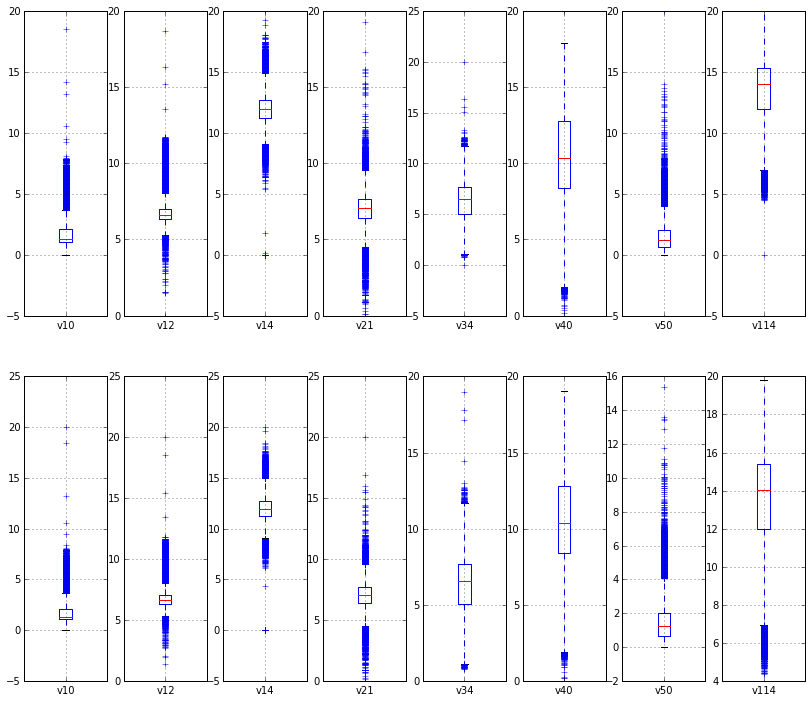

In [48]:
# Plotting these 8 numerical variables for both train and test sets with boxplots.
fig, axs = plt.subplots(2, 8, figsize=(14,12))
for i, ind in enumerate(variables_less_null):
    df_train[[column_names[ind]]].boxplot(return_type='axes', ax=axs[0,i])
    df_test[[column_names[ind]]].boxplot(return_type='axes', ax=axs[1,i])
plt.show()

These 8 variables have similar distributions in both train and test sets.

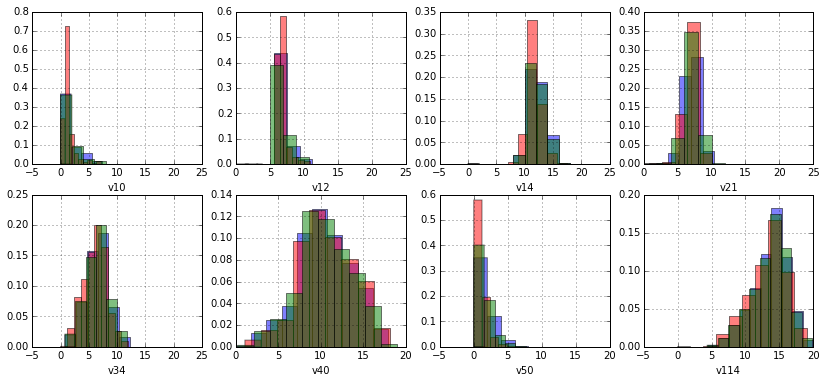

In [49]:
# Plotting distributions these 8 numerical variables for the train sets for target 0 and target 1
fig, axs = plt.subplots(2, 4, figsize=(14,6))
axs_list = axs.flatten()
for i, ind in enumerate(variables_less_null):
    df_train[target_train == 1][column_names[ind]].hist(alpha=0.5, normed=True, ax=axs_list[i], color='b')
    df_train[target_train == 0][column_names[ind]].hist(alpha=0.5, normed=True, ax=axs_list[i], color='r')
    df_test[column_names[ind]].hist(alpha=0.5, normed=True, ax=axs_list[i], color='g')
    axs_list[i].set_xlabel(column_names[ind])
plt.show()

These 8 variables have similar distributions for sets with target 1 and target 0, and also with the test set.

## Feature importance

So far we have found these:

(1) There are two kinds of data points: one with very little nulls, and the other with more than 80 nulls. Therefore, we will attempt to divide rows of the train set into two sets (df_train1 and df_train2), and use different variables/methods.
(2) We also know category variables (23 total) have 7 variables that seem to have statistical significance.
(3) Out of 108 numerical variables, 8 variables have less than 1% missing values, while 100 variables have about 1/3 missing.

Now we have some ideas on how to approach this dataset. First we will divide rows into two groups. Then we will look at them separately.

In [50]:
df_train1 = df_train[~mask_null_over_80_train].copy() # Set with less than 80 nulls (mostly 0 null)
df_test1 = df_test[~mask_null_over_80_test].copy()
df_train2 = df_train[mask_null_over_80_train].copy()  # Set with more than 80 nulls (mostly 100 nulls)
df_test2 = df_test[mask_null_over_80_test].copy()
# We will replace nulls with the mean value of that column
df_test1_imputed = df_test1.copy()
df_test1_imputed.fillna(df_test1.mean(), inplace=True)
df_test2_imputed = df_test2.copy()
# Here only impute some columns including 8 variables we need. (Some columns have all nulls and no mean value.)
df_test2_imputed.fillna(df_test2.mean(), inplace=True)
print df_test1_imputed.isnull().sum().sum(), df_test2_imputed.iloc[:,variables_less_null].isnull().sum().sum()

0 0


In [51]:
# Their shapes
print df_train1.shape, df_train2.shape, df_test1.shape, df_test2.shape

(64525, 134) (49796, 134) (64553, 134) (49840, 134)


In [52]:
# Their percentages of nulls for numerical variables (nulls for category variables were not counted).
print df_train1.isnull().sum().sum()/float(df_train1.shape[0]*df_train.shape[1])*100,\
    df_train2.isnull().sum().sum()/float(df_train2.shape[0]*df_train.shape[1])*100
print df_test1.isnull().sum().sum()/float(df_test1.shape[0]*df_test.shape[1])*100,\
    df_test2.isnull().sum().sum()/float(df_test2.shape[0]*df_test.shape[1])*100

0.299941593852 74.0537662319
0.298909770081 74.0474443593


0.3% of cells are nulls for the first set, and 74% of cells are nulls for the second set.

### For the first set of data (df_train1 with 3% of nulls; numerical variables only)

In [53]:
# To see the feature importance, we will drop rows with null values in the numerical variables in the set 1.
# To do that, we fill 'null' in the missing values of category variables first (which is done already).
df_train1_dropped_na = df_train1.dropna()
print df_train1_dropped_na.shape, "Dropped %.2f%%." % (100-100.0*df_train1_dropped_na.shape[0]/df_train1.shape[0])

(62561, 134) Dropped 3.04%.


In [54]:
# Get X and y for the train set. (only including the numerical varaibles)
y1 = np.array(target_train.loc[df_train1_dropped_na.index])
X11 = df_train1_dropped_na[numerical_variables].values
print y1.shape, X11.shape

(62561,) (62561, 108)


In [55]:
# Using the random forest to find the feature importances for numerical variables only.
rf11 = RandomForestClassifier(n_estimators=100, oob_score=True)
rf11 = rf11.fit(X11, y1)

To run the random forest model, we only looked at numerical variables first.

In [56]:
# Find the sorted important variables and their importances, and look at top 10.
indices_important_variables11 = np.argsort(rf11.feature_importances_)[::-1]
important_variable_names11 = df_train1_dropped_na[numerical_variables].columns[indices_important_variables11]
importances11 = rf11.feature_importances_[indices_important_variables11]
print important_variable_names11[:10]
print importances11[:10]

Index([u'v50', u'v10', u'v12', u'v14', u'v21', u'v34', u'v114', u'v40', u'v6',
       u'v88'],
      dtype='object')
[ 0.05763456  0.02157259  0.01998801  0.01791123  0.01508179  0.01374521
  0.01362545  0.01281962  0.01008235  0.01006897]


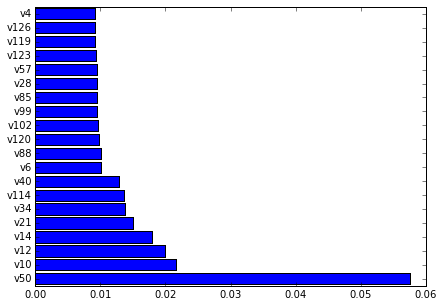

In [57]:
# Look at above results in a bar chart.
num_var = 20 # Number of top variables
plt.figure(figsize=(7, 5))
y_locations = np.arange(num_var) + 0.5
plt.barh(y_locations, importances11[:num_var], align='center')
plt.yticks(y_locations, important_variable_names11[:num_var])
plt.show()

v50 seems to be the most important variable for this set. After 8 variables importances are almost the same. These 8 variables are exactly the same variables that have less than 1% nulls.

In [58]:
#rf11 = rf11.fit(X11, y1)
rf11.oob_score_

0.75144259203017849

Out of bag score is ~75%. Doesn't look good at this moment. Now we will add category variables by making dummy variables. Since some of them do not look significant and some has too many possible values, we will just add 7 category variables.

### For the first set of data (df_train1 with 3% of nulls; all numerical variables + top 10 category variables)

In [67]:
# For simplicity, we will only consider top 10 category variables (including 3 engineered).
df1 = pd.concat([df_train1_dropped_na.reset_index(), df_test1_imputed.reset_index()])
df1_temp = df1[['ID'] + list(column_names[numerical_variables])] # Initially it has only numerical variables
for ind in category_variables_top10:
    df_dummy = pd.get_dummies(df1[column_names[ind]], prefix=column_names[ind])
    #print column_names[ind], df_dummy.shape, df_dummy.isnull().sum().sum()
    df_dummy.drop(df_dummy.columns[:1], axis=1, inplace=True)
    df1_temp = pd.concat([df1_temp, df_dummy], axis=1)

In [68]:
# Create X12, X1_test, y1 for analysis
X12 = df1_temp.iloc[:df_train1_dropped_na.shape[0],1:].values 
X1_test = df1_temp.iloc[df_train1_dropped_na.shape[0]:,1:].values
y1 = np.array(target_train.loc[df_train1_dropped_na.index])
print y1.shape, X12.shape, X1_test.shape

(62561,) (62561, 182) (64553, 182)


In [69]:
# Using the random forest to find the feature importances for numerical variables + 7 category variables.
rf12 = RandomForestClassifier(n_estimators=100, oob_score=True)
rf12 = rf12.fit(X12, y1)

In [81]:
# Find the sorted important variables and their importances, and look at top 10.
indices_important_variables12 = np.argsort(rf12.feature_importances_)[::-1]
important_variable_names12 = df1_temp.columns[indices_important_variables12 + 1]
importances12 = rf12.feature_importances_[indices_important_variables12]
print important_variable_names12[:10]
print importances12[:10]

Index([u'v50', u'v22a_10', u'v10', u'v12', u'v14', u'v114', u'v34', u'v40',
       u'v21', u'v28'],
      dtype='object')
[ 0.05019924  0.04510812  0.01398747  0.01372087  0.01239319  0.01145063
  0.01117646  0.01106077  0.01047328  0.00895091]


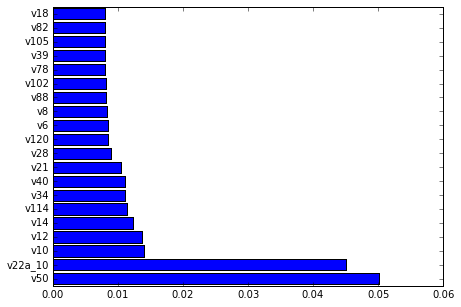

In [82]:
# Look at above results in a bar chart.
num_var = 20 # Number of top variables
plt.figure(figsize=(7, 5))
y_locations = np.arange(num_var) + 0.5
plt.barh(y_locations, importances12[:num_var], align='center')
plt.yticks(y_locations, important_variable_names12[:num_var])
plt.show()

Even with added category variables, 8 most important features (variables) are the same. But a category variable v22
stands out with v50.

In [83]:
#rf12 = rf11.fit(X12, y1)
rf12.oob_score_

0.78285193650996632

Out of bag score is higher, so we need to definitely use category variables.

### For the first set of data (df_test1 with 3% of nulls; all numerical variables + top 10 category variables)

In [84]:
# Trying to predict the test set (only the first set with less nulls).
y1_test_prob = rf12.predict_proba(X1_test)[:,1]

In [85]:
y1_test_prob = pd.DataFrame(y1_test_prob, index=df_test1.index, columns=['PredictedProb'])

### For the second set of data (df_train2 with 75% of nulls; 8 numerical variables + top 10 category variables)
Here since there are too many nulls for other 100 numerical variables, we will ignore these variables.

In [86]:
df_train2_dropped_na = df_train2[list(variables_less_null) + category_variables_top10].dropna()
print df_train2_dropped_na.shape, "Dropped %.2f%%." % (100-100.0*df_train2_dropped_na.shape[0]/df_train2.shape[0])

(49483, 18) Dropped 0.63%.


In [87]:
# Creating dummy variables. reset_index should be used because ID orders have to be preserved
df2 = pd.concat([df_train2_dropped_na.reset_index(), df_test2_imputed[list(variables_less_null) + \
                                                    category_variables_top10].reset_index()])
df2_temp = df2[['ID'] + list(column_names[variables_less_null])]
for ind in category_variables_top10:
    df_dummy = pd.get_dummies(df2[column_names[ind]], prefix=column_names[ind])
    #print column_names[ind], df_dummy.shape, df_dummy.isnull().sum().sum()
    df_dummy.drop(df_dummy.columns[:1], axis=1, inplace=True)
    df2_temp = pd.concat([df2_temp, df_dummy], axis=1)

In [88]:
# Create X2, X2_test, y2 for analysis
X2 = df2_temp.iloc[:df_train2_dropped_na.shape[0],1:].values 
X2_test = df2_temp.iloc[df_train2_dropped_na.shape[0]:,1:].values
y2 = np.array(target_train.loc[df_train2_dropped_na.index])
print X2.shape, X2_test.shape, y2.shape

(49483, 79) (49840, 79) (49483,)


In [89]:
rf2 = RandomForestClassifier(n_estimators=100, oob_score=True)
rf2 = rf2.fit(X2, y2)

In [90]:
# Find the sorted important variables and their importances.
indices_important_variables2 = np.argsort(rf2.feature_importances_)[::-1]
important_variable_names2 = df2_temp.columns[indices_important_variables2 + 1]
importances2 = rf2.feature_importances_[indices_important_variables2]
print important_variable_names2
print importances2

Index([u'v50', u'v12', u'v21', u'v114', u'v40', u'v34', u'v14', u'v10',
       u'v22a_10', u'v22a_8', u'v66_C', u'v22a_9', u'v56a_7', u'v22a_7',
       u'v66_B', u'v22a_5', u'v113a_5', u'v62_1', u'v56a_2', u'v56a_5',
       u'v22a_4', u'v113a_2', u'v62_2', u'v79_B', u'v110_B', u'v22a_6',
       u'v47_C', u'v56a_6', u'v79_C', u'v113a_3', u'v31_B', u'v56a_4',
       u'v47_I', u'v129_1', u'v113a_1', u'v79_E', u'v62_3', u'v22a_3',
       u'v56a_3', u'v79_I', u'v47_E', u'v56a_8', u'v79_D', u'v47_G', u'v79_M',
       u'v129_2', u'v47_J', u'v79_H', u'v79_K', u'v47_F', u'v113a_4', u'v79_Q',
       u'v22a_2', u'v31_C', u'v56a_9', u'v62_4', u'v79_O', u'v129_3',
       u'v56a_1', u'v31_null', u'v79_P', u'v113a_7', u'v110_C', u'v62_5',
       u'v47_D', u'v79_J', u'v129_4', u'v79_F', u'v129_5', u'v113a_6',
       u'v129_6', u'v79_G', u'v62_6', u'v79_N', u'v56a_10', u'v79_R', u'v47_B',
       u'v113a_9', u'v79_L'],
      dtype='object')
[  1.30744722e-01   8.63567280e-02   8.06055008e-02   8.0444357

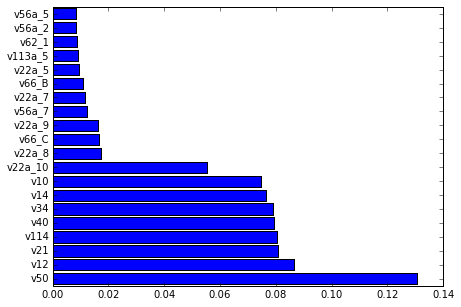

In [91]:
# Look at above results in a bar chart.
num_var = 20
plt.figure(figsize=(7, 5))
y_locations = np.arange(num_var) + 0.5
plt.barh(y_locations, importances2[:num_var], align='center')
plt.yticks(y_locations, important_variable_names2[:num_var])
plt.show()

In [92]:
#rf2 = rf2.fit(X2, y2)
rf2.oob_score_

0.80841905300810379

### For the second set of data (df_test2 with 75% of nulls; 8 numerical variables + top 10 category variables)

In [93]:
# Trying to predict the test set (only the first set with less nulls).
y2_test_prob = rf2.predict_proba(X2_test)[:,1]

In [94]:
y2_test_prob = pd.DataFrame(y2_test_prob, index=df_test2.index, columns=['PredictedProb'])

### Combining the predicted probabilities of two sets and writing to a csv file

In [95]:
pd.concat([y1_test_prob, y2_test_prob]).sort_index().to_csv('test_submission.csv')

This was just a test submission, and more has to be done: (1) tweaking feature selections and feature engineering; (2) model selections and grid searches (in a faster machine) using CV; (3) refining coding (making functions on data preprocessing), etc.

### Trying the whole data using only 8 numerical variables and top 10 category variables (without dividing data)

In [116]:
df_train_dropped_na = df_train[list(variables_less_null) + category_variables_top10].dropna()
print df_train_dropped_na.shape, "Dropped %.2f%%." % (100-100.0*df_train_dropped_na.shape[0]/df_train.shape[0])

(113684, 18) Dropped 0.56%.


In [121]:
df_test_imputed = df_test[list(variables_less_null) + category_variables_top10].copy()
df_test_imputed.fillna(df_test_imputed.mean(), inplace=True)
print df_test_imputed.shape, df_test_imputed.isnull().sum().sum()

(114393, 18) 0


In [122]:
# Creating dummy variables. reset_index should be used because ID orders have to be preserved
df = pd.concat([df_train_dropped_na.reset_index(), df_test_imputed.reset_index()])
df_temp = df[['ID'] + list(column_names[variables_less_null])]
for ind in category_variables_top10:
    df_dummy = pd.get_dummies(df[column_names[ind]], prefix=column_names[ind])
    #print column_names[ind], df_dummy.shape, df_dummy.isnull().sum().sum()
    df_dummy.drop(df_dummy.columns[:1], axis=1, inplace=True)
    df_temp = pd.concat([df_temp, df_dummy], axis=1)
print df_temp.shape

(228077, 84)


In [123]:
# Create X, X_test, y for analysis
X = df_temp.iloc[:df_train_dropped_na.shape[0],1:].values 
X_test = df_temp.iloc[df_train_dropped_na.shape[0]:,1:].values
y = np.array(target_train.loc[df_train_dropped_na.index])
print X.shape, X_test.shape, y.shape

(113684, 83) (114393, 83) (113684,)


In [124]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
rf = rf.fit(X, y)

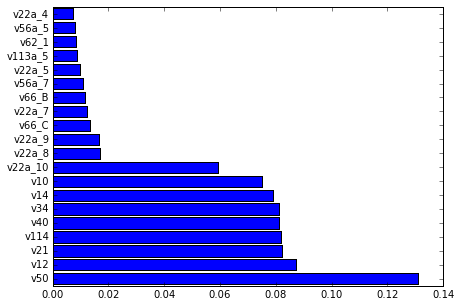

In [125]:
# Find the sorted important variables and their importances.
indices_important_variables = np.argsort(rf.feature_importances_)[::-1]
important_variable_names = df_temp.columns[indices_important_variables + 1]
importances = rf.feature_importances_[indices_important_variables]
# Look at above results in a bar chart.
num_var = 20
plt.figure(figsize=(7, 5))
y_locations = np.arange(num_var) + 0.5
plt.barh(y_locations, importances[:num_var], align='center')
plt.yticks(y_locations, important_variable_names[:num_var])
plt.show()

In [126]:
rf.oob_score_

0.79871397909996134

In [129]:
y_test_prob = rf.predict_proba(X_test)[:,1]
y_test_prob = pd.DataFrame(y_test_prob, index=df_test.index, columns=['PredictedProb'])
y_test_prob.to_csv('test_submission.csv')

In [128]:
y_test_prob.shape

(114393,)

## Looking at variable-variable correlations
So far we have been assuming that variables are independent with each other. But there might be some correlations between variables. Here we will look at 8 numerical variables with less nulls.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3977db9f10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3971bdf590>]], dtype=object)

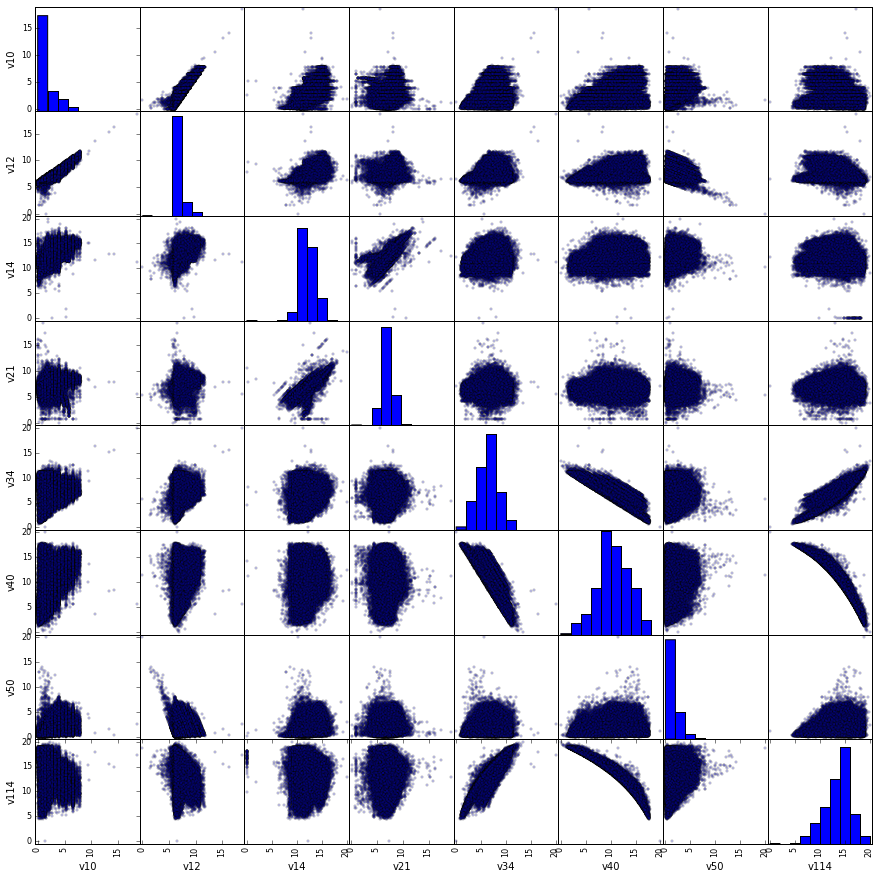

In [115]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df_train[variables_less_null], figsize=(15, 15), alpha=0.2)

We can see many patterns for some reasons. They are quite correlated. Therefore we might need to do something. Maybe PCA?